**1. Importing the dependencies**

In [88]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from xgboost import XGBClassifier
import pickle
sns.set_style('darkgrid')

**2. Data Loading and Understanding**

In [90]:
from google.colab import drive
drive.mount('/content/drive')

# Kiểm tra đường dẫn thực tế của thư mục dataset/train
!ls "/content/drive/My Drive/Churn Prediction/dataset/"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data_descriptions.csv  test.csv  train.csv


In [91]:
data_descriptions = pd.read_csv('/content/drive/My Drive/Churn Prediction/dataset/data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly basis.
2,TotalCharges,Feature,float,The total charges incurred by the user over the account's lifetime.
3,SubscriptionType,Feature,object,"The type of subscription chosen by the user (Basic, Standard, or Premium)."
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paperless billing (Yes or No).
6,ContentType,Feature,string,"The type of content preferred by the user (Movies, TV Shows, or Both)."
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the service on multiple devices (Yes or No).
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV, Mobile, Tablet, or Computer)."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching content per week.


In [92]:
df = pd.read_csv("/content/drive/My Drive/Churn Prediction/dataset/train.csv")
print('df Shape:', df.shape)
# test_df = pd.read_csv("/content/drive/My Drive/Churn Prediction/dataset/test.csv")
# print('test_df Shape:', test_df.shape)

df Shape: (243787, 21)


In [93]:
pd.set_option('display.max_columns', None)


# Customer Churn Prediction


## Data Preparation

In [94]:
def datapreparation(filepath):
    df = pd.read_csv(filepath)

    # Tạo một bản sao của DataFrame để tránh SettingWithCopyWarning
    df = df.copy()

    # Loại bỏ cột CustomerID nếu có
    if 'CustomerID' in df.columns:
        df.drop(['CustomerID'], axis=1, inplace=True)

    # Xử lý cột TotalCharges nếu có dữ liệu bị thiếu hoặc khoảng trắng
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan).astype(float)
        df['TotalCharges'] = df['TotalCharges'].fillna(0)

    # Chuyển đổi các cột nhị phân từ Yes/No sang 1/0
    binary_cols = ['PaperlessBilling', 'SubtitlesEnabled', 'ParentalControl', 'MultiDeviceAccess']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'Yes': 1, 'No': 0})

    # Chuyển đổi giới tính thành số (Male -> 0, Female -> 1)
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

    # Xử lý các giá trị danh mục bằng One-Hot Encoding
    categorical_cols = ['SubscriptionType', 'PaymentMethod', 'ContentType', 'DeviceRegistered', 'GenrePreference']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

    return df


In [95]:
# Xử lý dữ liệu training
df = datapreparation("/content/drive/My Drive/Churn Prediction/dataset/train.csv")
print('Processed df Shape:', df.shape)

# Xử lý dữ liệu testing
# test_df = datapreparation("/content/drive/My Drive/Churn Prediction/dataset/test.csv")
# print('Processed test_df Shape:', test_df.shape)


Processed df Shape: (243787, 34)


In [96]:
df.head(10)

,AccountAge,MonthlyCharges,TotalCharges,PaperlessBilling,MultiDeviceAccess,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,Churn,SubscriptionType_Basic,SubscriptionType_Premium,SubscriptionType_Standard,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,ContentType_Both,ContentType_Movies,ContentType_TV Shows,DeviceRegistered_Computer,DeviceRegistered_Mobile,DeviceRegistered_TV,DeviceRegistered_Tablet,GenrePreference_Action,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi
0,20,11.055215,221.104302,0,0,36.758104,63.531377,10,2.176498,4,0,3,0,0,0,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True
1,57,5.175208,294.986882,1,0,32.450568,25.725595,18,3.478632,8,0,23,0,1,0,True,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False
2,73,12.106657,883.785952,1,0,7.395160,57.364061,23,4.238824,6,0,1,1,1,0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,False
3,32,7.263743,232.439774,0,0,27.960389,131.537507,30,4.276013,2,0,24,1,1,0,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False
4,57,16.953078,966.325422,1,0,20.083397,45.356653,20,3.616170,4,1,0,0,0,0,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False
5,113,7.295744,824.419081,1,0,21.678290,97.095746,35,3.721134,8,1,2,1,1,0,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,True,False,False,False
6,38,12.340675,468.945639,0,0,36.512761,81.782993,28,4.090868,9,1,20,0,1,0,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
7,25,7.247550,181.188753,1,0,16.355816,154.521682,10,3.410221,2,1,22,0,0,0,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False
8,26,19.803233,514.884050,0,0,8.202929,94.375211,28,2.679986,0,0,5,1,1,1,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False
9,14,18.842934,263.801080,0,0,38.560694,122.012890,0,2.993441,0,0,18,0,0,0,False,False,True,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False


In [97]:
df.isnull().any().any()
#df.isnull().any().any()

False

In [98]:
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify = df.Churn)

## Model building

In [99]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]


# In kích thước dữ liệu sau khi tách
print("Train X Shape:", train_x.shape)
print("Train Y Shape:", train_y.shape)
print("Test X Shape:", test_x.shape)
print("Test Y Shape:", test_y.shape)


Train X Shape: (195029, 33)
Train Y Shape: (195029,)
Test X Shape: (48758, 33)
Test Y Shape: (48758,)


# Using SMOTE for Imbalanced Dataset

In [100]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Khởi tạo SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Churn=1 sẽ bằng 50% Churn=0

# Áp dụng SMOTE để tăng dữ liệu Churn=1
train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)

# Kiểm tra lại tỷ lệ sau khi xử lý
print("Tỷ lệ trước SMOTE:\n", train_y.value_counts(normalize=True))
print("Tỷ lệ sau SMOTE:\n", pd.Series(train_y_resampled).value_counts(normalize=True))


Tỷ lệ trước SMOTE:
 Churn
0    0.818771
1    0.181229
Name: proportion, dtype: float64
Tỷ lệ sau SMOTE:
 Churn
0    0.666667
1    0.333333
Name: proportion, dtype: float64


In [101]:
train_x = train_x_resampled
train_y = train_y_resampled

In [102]:
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]

    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)

    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)

    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))

    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities)
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")

    plt.show()





## Grid 1: Selecting class weight and estimators



In [103]:
param_grid1 = {'max_features':['sqrt', 'log2', None],
          'n_estimators':[30, 40, 50, 70]
         }

rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=2, cv=2, verbose=1, scoring = 'f1')
grid1.fit(train_x, train_y)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [30, 40, 50, 70]},
             scoring='f1', verbose=1)

In [ ]:
import gc

del grid1  # Xóa Grid Search cũ
gc.collect()  # Giải phóng RAM

3411

In [104]:
grid1.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=70)

In [105]:
grid1.best_score_

0.5437233561222931

In [106]:
grid1.best_estimator_.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 70,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Grid 2: Selecting max depth and split criterion



In [107]:
param_grid2 = {'max_features':['log2'],
          'n_estimators':[60 ,70, 80],
           'criterion': ['entropy', 'gini'],
          'max_depth': [5, 7, 9, None],
         }

rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=2, cv=2, verbose=1, scoring = 'f1')
grid2.fit(train_x, train_y)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 7, 9, None], 'max_features': ['log2'],
                         'n_estimators': [60, 70, 80]},
             scoring='f1', verbose=1)

In [108]:
grid2.best_score_

0.542827106642199

In [109]:
grid2.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [110]:
param_grid2_2 = {'max_features':['log2'],
          'n_estimators':[80],
           'criterion': ['gini'],
          'max_depth': [2, 3, 5, 7, 9, 11, 13, None],
         }

rf_model = RandomForestClassifier()
grid2_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2_2, n_jobs=2, cv=2, verbose=1, scoring = 'f1')
grid2_2.fit(train_x, train_y)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini'],
                         'max_depth': [2, 3, 5, 7, 9, 11, 13, None],
                         'max_features': ['log2'], 'n_estimators': [80]},
             scoring='f1', verbose=1)

In [111]:
grid2_2.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [112]:
grid2_2.best_score_

0.5431398120430905

## Grid 3: Selecting minimum samples leaf and split



In [114]:
param_grid3 = {'max_features':['log2'],
          'n_estimators':[80],
           'criterion': ['gini'],
          'max_depth': [None],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=2, cv=2, verbose=1, scoring = 'f1')
grid3.fit(train_x, train_y)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [80]},
             scoring='f1', verbose=1)

In [115]:
grid3.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [116]:
grid3.best_score_

0.5456375773773189

# Grid 4: Selecting class weight

In [117]:
param_grid4 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
            'max_features':['log2'],
          'n_estimators':[80],
           'criterion': ['gini'],
          'max_depth': [None],
          'min_samples_leaf': [1],
          'min_samples_split': [2]
         }

rf_model = RandomForestClassifier()
grid4 = GridSearchCV(estimator=rf_model, param_grid=param_grid4, n_jobs=2, cv=3, verbose=1, scoring = 'f1')
grid4.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['log2'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [80]},
             scoring='f1', verbose=1)

<Axes: ylabel='param_class_weight'>

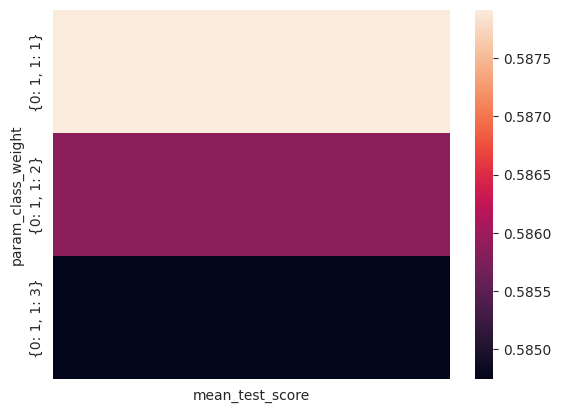

In [118]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')

sns.heatmap(table)

In [119]:
grid4.best_score_

0.5879149650995149

# Final Model

In [120]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight={0: 1, 1: 1},
    criterion='gini',
    max_depth=None,
    max_features='log2',
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=80,
    n_jobs=None,
    oob_score=False,
    random_state=None,
    verbose=0,
    warm_start=False
)


RandomForestClassifier(class_weight={0: 1, 1: 1}, max_features='log2',
                       n_estimators=80)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.98      0.90     39921
           1       0.53      0.10      0.16      8837

    accuracy                           0.82     48758
   macro avg       0.68      0.54      0.53     48758
weighted avg       0.78      0.82      0.77     48758

Accuracy   Score :  0.8204397227121704
Area under curve :  0.723548298939404 



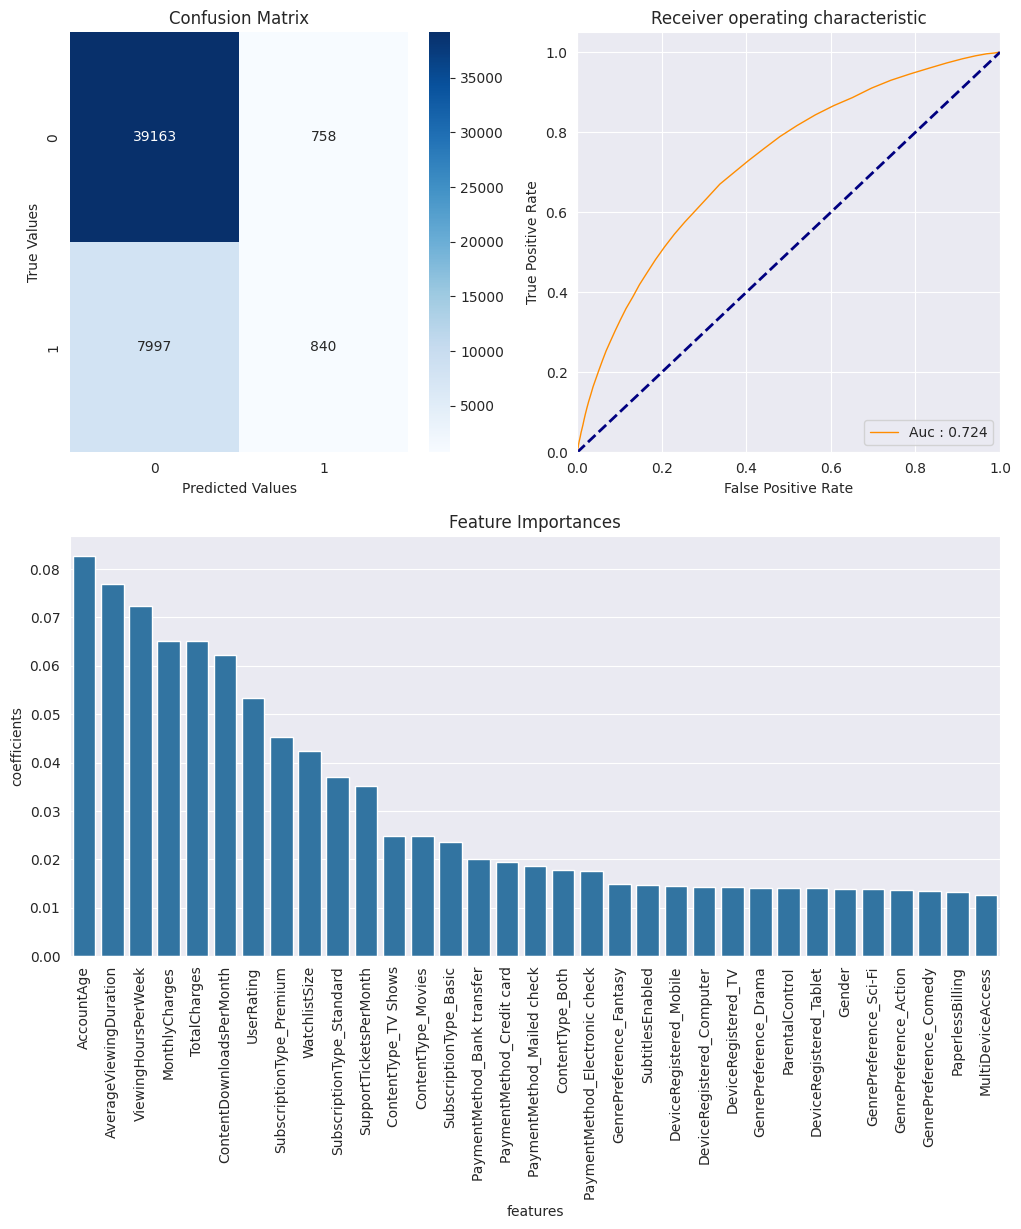

In [121]:
churn_prediction(model, train_x, train_y, test_x, test_y, x,"features")

In [124]:
import pickle
pickle.dump(model, open('model.pkl','wb'))